In [1]:
#!/usr/bin/env python
# coding: utf-8

# # Plot Simulation Results

# In[23]:

import numpy as np
import pandas as pd
import sys

import matplotlib.pyplot as plt
from scipy.spatial import distance
import statistics
from sklearn import metrics
from tqdm import tqdm
from Bio.Align import PairwiseAligner
import os

home_dir = "/home/work/tkoike/dna-triplet-network/"
aligner = PairwiseAligner()
aligner.mode = "global"
aligner.match_score = 2
aligner.mismatch_score = -1
aligner.gap_score = -1

def inference_label(k, data):
  knn=data.apply(lambda x: x[np.argsort(-x).values].index[:k],axis=1)
  mode = knn.apply(lambda x: statistics.multimode(x.map(lambda y: int(y.split("_")[-1]))))
  # mode = knn.apply(lambda x: scipy.stats.mode(x.map(lambda y: int(y.split("_")[-1])))[0])
  return mode.apply(lambda x: x[0]).values

def score(sh_hamming):
  label=np.array([int(x.split('_')[-1]) for x in sh_hamming.index])
  # print(str(k)+"NN")
  # pred = inference_label(k,sh_hamming)
  # pred=np.argmax(sh_hamming.values,axis=1)

  pred=sh_hamming.values
  # for i in [1,3,5]:
  i=1
  print("Top-{} accuracy:".format(i),metrics.top_k_accuracy_score(label, pred,k=i))
  ans=np.argmax(sh_hamming.values,axis=1)
  rec_score=metrics.recall_score(label,ans,average=None)
  pre_score=metrics.precision_score(label,ans,average=None)
  f1_score=metrics.f1_score(label,ans,average=None)
  # print("rec_score:",rec_score)
  print("rec_score macro:",np.average(rec_score))
  # print("pre_score:",pre_score)
  print("pre_score macro:",np.average(pre_score))
  # print("f1_score:",f1_score)
  print("f1_score macro:",np.average(f1_score))

def alignment_score(path, q_method, t_method):
  queries = pd.read_hdf(path.format("queries",q_method))
  targets = pd.read_hdf(path.format("targets",t_method))
  align_score = pd.DataFrame(columns=queries.index,index=targets.index)

  for q_i, q_val in tqdm(queries.iterrows(),total = len(queries)):
    for i, val in tqdm(targets.iterrows(), leave=False, total=len(targets)):
      align = aligner.align(val.FeatureSequence, q_val.FeatureSequence)
      align_score.loc[i,q_i] = align[0].score

  return align_score

def nnrecall_ave(sh_hamming, data, path):
  ave_nnrecall = np.zeros(shape=(100,))
  for i in range(10):
    label = "label_"+str(i)
    nnrecall = np.where(sh_hamming.sort_values(label,ascending=False).index.str.endswith("_"+str(i)))[0][:1000]+1
    ave_nnrecall += nnrecall
  ave_nnrecall /= 10
  return ave_nnrecall


majority-query-triplet-cifar100-len80.h5
majority-query-primo-cifar100-len80.h5


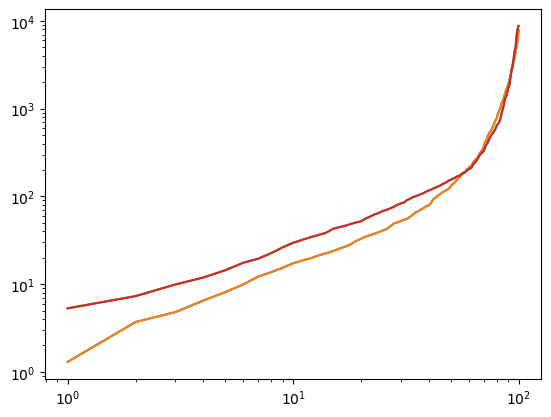

In [2]:
global tran
dataset="cifar100/"#input("dataset:")+"/"
model="vgg16/" #input("model:")+"/"
data_list=os.listdir(home_dir+dataset+"simulation/"+model)
path = home_dir+dataset+"{}/"+model+"dim4096/{}-feature_seqs.h5"
for data in reversed(data_list):
  if("triplet" in data) and ("majority" in data):
    if("iccad" in data):
      continue
    print(data)
    sh_hamming=pd.read_hdf(home_dir+dataset+"simulation/"+model+data)
    ave_nn_triplet = nnrecall_ave(sh_hamming, data, path)
    model_name={"vgg16/":"VGG-16", "resnet50/":"ResNet50","xception/":"Xception","efficientnetv2s/":"EfficientNetV2-S"}
    line_style = "-"
    plt.plot([1+i for i in range(100)],ave_nn_triplet,label="proposed ({})".format(model_name[model]), linestyle=line_style) 
    plt.plot([1+i for i in range(100)],ave_nn_triplet,label="proposed ({})".format(model_name[model]), linestyle=line_style) 
  elif("primo" in data) and (model == "vgg16/") and ("majority" in data):
    if("iccad" in data):
      continue
    print(data)
    sh_hamming=pd.read_hdf(home_dir+dataset+"simulation/"+model+data)
    ave_nn_primo = nnrecall_ave(sh_hamming, data, path)
    plt.plot([1+i for i in range(100)],ave_nn_primo,label="primo") 
    plt.plot([1+i for i in range(100)],ave_nn_primo,label="primo") 
plt.xscale("log")
plt.yscale("log")

[4.07692308 1.97297297 2.0625     1.83076923 1.77777778 1.76767677
 1.59836066 1.64963504 1.70779221 1.71098266]


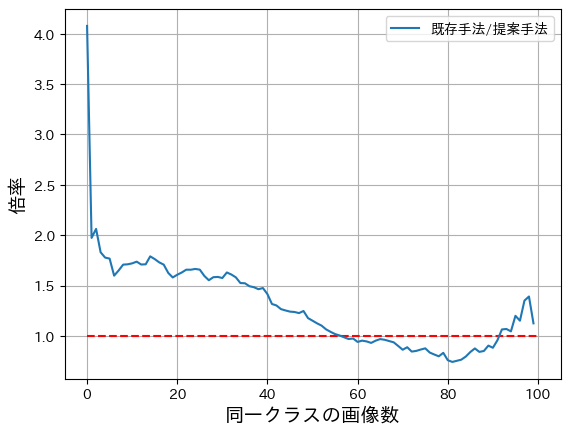

In [3]:
import japanize_matplotlib
print((ave_nn_primo/ave_nn_triplet)[:10])
plt.plot(list(range(100)),ave_nn_primo/ave_nn_triplet, label="既存手法/提案手法")
plt.hlines(1,0,100, linestyles='dashed', color='red')
plt.xlabel("同一クラスの画像数", fontsize=14)
plt.ylabel("倍率", fontsize=14)
plt.grid()
plt.legend()
# plt.savefig("nnrecall_ave_rate.svg")